# 機械学習の解釈手法
ICE, SHAPに絞る。

### データ、モデル準備
CRIM: 人口一人当たりの犯罪発生数　を目的変数とする。<br>
とりあえずRFでモデル作成、fitまで行う。

In [40]:
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

# 説明変数,目的変数
y_col = 'CRIM'
X = df.drop(y_col, axis=1)  # 説明変数(CRIM以外の特徴量)
y = df[y_col]  # 目的変数(CRIM)

# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Random Forestの学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)



Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

RandomForestRegressor(n_jobs=-1, random_state=42)

In [41]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## ICE(Indeividual Conditional Expectation)
その他の特徴量の値が固定された状態で、もしある特徴量の値が変化した場合に予測値はどう変化するのか

利点
- 特徴量の交互作用を捉えることができる。

注意点
- モデルが特徴量と目的変数の関係を正しく捉えられていなければ、ICEは因果関係として解釈することはできない。
- 平均をとっていないので、値が安定しない傾向がある。CPD(Conditional Partial Dependence)を併用して対策する。
- できるだけ実際の値の近傍で解釈する。

### 実装

In [42]:
from sklearn.inspection import partial_dependence

feature = "RAD"
# PDとICEを計算
ice = partial_dependence(
    estimator=rf,
    X=X_test,
    features=[feature],
    kind='both',
)

今回は、RAD: 環状高速道路へのアクセスのしやすさ　を例に取って見てみる。

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


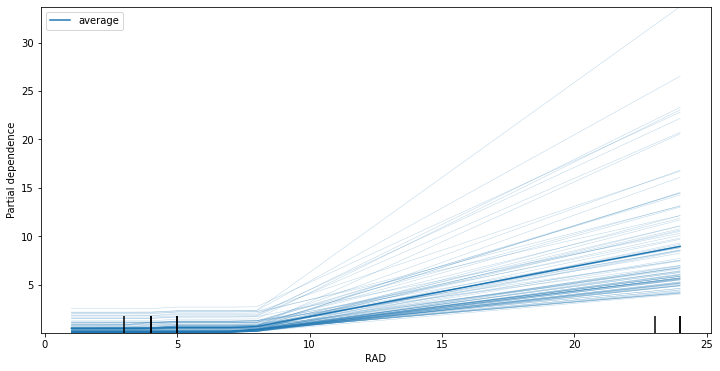

In [56]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

def plot_ice(feature):
    """ICEを可視化"""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_partial_dependence(
        estimator=rf, # 学習済みモデル
        X=X_test, # ICEを計算したいデータ
        features=feature, # ICEを計算したい特徴量
        kind='both', # PDは"average", ICEは"individual", 両方は"both"
        ax = ax,
    )
    fig.show()

# ICEを可視化
feature = ["RAD"]
plot_ice(feature)
    

環状高速道路へのアクセスのしやすさが大きいほど、予測値が高くなっていることがわかる。平均的な傾向とは異なる動きを見せるインスタンスが今回は存在しないため、PDだけでも良いかもしれない。

## SHAP(SHapley Addictive exPlanations)
モデルがなぜそのような予測値を出したのか。

注意点
- 特徴量が変化した際に予測値がどう反応するかは分からない。ICEを併用して対策する。
- 計算コストが高い。

限界貢献度
- 例えば、各人がアルバイトに参加したとき、参加しなかった時と比べて、追加的のどのくらい報酬が増えるか。

Shapley値
- 平均的な限界貢献度のこと


モデルに投入した特徴量Xをゲームのプレイヤーと見立て、特徴量jの値がわかっている時とわかっていない時の予測値の差分を用いる。順番の影響を取り除くために、考えうる全ての順番で特徴量の値がわかった時の予測値に与える影響を計算し、それを平均しなければいけない。

SHAP値
- 上において、その平均した値をSHAP値と呼ぶ。インスタンスの予測値に対して特徴量jが与える平均的な影響を表す。

## 実装

データとモデルは、最初に用意したものを用いる。

In [44]:
import shap

# SHAP値を計算するためのexplainerを作成
explainer = shap.TreeExplainer(
    model=rf, # 学習済みモデル
    data=X_test, # SHAPを計算するためのデータ
    feature_pertubation='interventional', # 推奨
)


explainerにSHAP値を計算したいデータを与えることで、SHAP値が計算できる。

In [47]:
shap_values = explainer(X_train)

shap_valuesにはSHAP値だけでなく、各インスタンスの特徴量の値など、可視化に必要な情報が全て格納されている。

In [48]:
shap_values[0]

.values =
array([ 5.07021713e-03,  2.80818258e-02,  2.58702877e-03, -4.52964264e-02,
        8.74213506e-01, -2.52913473e-01, -2.57289972e-01,  7.92134949e+00,
        1.23097931e-01, -2.34692450e-02, -2.14883864e-01,  1.94056569e+00])

.base_values =
4.010576340000001

.data =
array([0.0000e+00, 1.8100e+01, 0.0000e+00, 6.1400e-01, 5.3040e+00,
       9.7300e+01, 2.1007e+00, 2.4000e+01, 6.6600e+02, 2.0200e+01,
       3.4948e+02, 2.4910e+01])

### SHAP値の可視化

インスタンス0、1についてのSHAP値を可視化する。

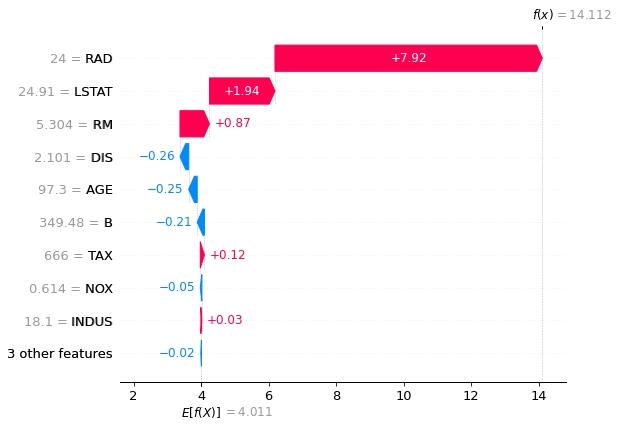

In [49]:
shap.plots.waterfall(shap_values[0])

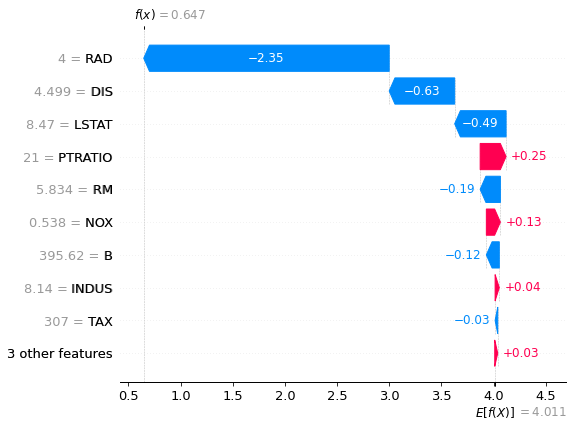

In [52]:
shap.plots.waterfall(shap_values[1])


### 特徴量重要度の可視化

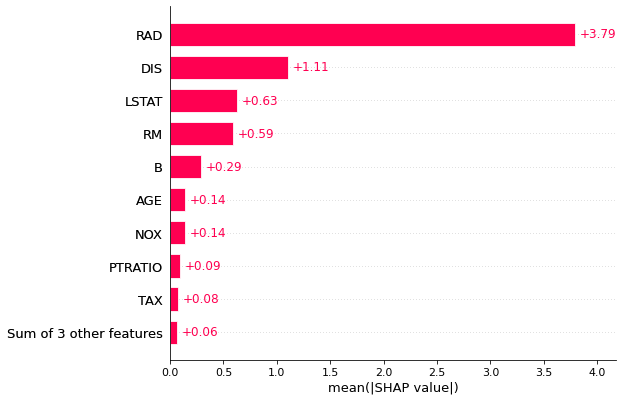

In [53]:
shap.plots.bar(shap_values=shap_values)

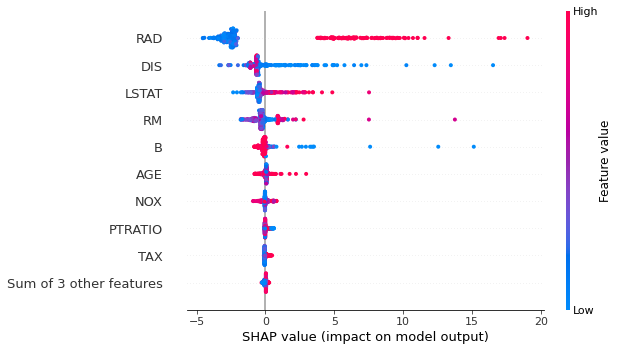

In [54]:
shap.plots.beeswarm(shap_values)

RADが予測値に与える影響は、-5から+20までインスタンスによって広く異なること、RADが高いほど予測値にプラスの影響を与えることが見てとれる。